Data source: https://dynamical.org/catalog/noaa-gfs-analysis-hourly/

Problem: Take the previous 5H of wind_u, wind_v and predict the next 5H of wind_u and wind_v in Denmark. 

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import torch 

from torch.utils.data import DataLoader, Dataset

In [13]:
print(f"MPS (Metal Performance Shaders) available: {torch.backends.mps.is_available()}")
print(f'Cuda is available: {torch.cuda.is_available()}')  

MPS (Metal Performance Shaders) available: True
Cuda is available: False


In [12]:
ds = xr.open_zarr("https://data.dynamical.org/noaa/gfs/analysis-hourly/latest.zarr")
ds 

<xarray.Dataset> Size: 1TB
Dimensions:                (latitude: 721, longitude: 1440, time: 82920)
Coordinates:
  * latitude               (latitude) float64 6kB 90.0 89.75 ... -89.75 -90.0
  * longitude              (longitude) float64 12kB -180.0 -179.8 ... 179.8
    spatial_ref            int64 8B ...
  * time                   (time) datetime64[ns] 663kB 2015-01-15 ... 2024-06...
Data variables:
    precipitation_surface  (time, latitude, longitude) float32 344GB ...
    temperature_2m         (time, latitude, longitude) float32 344GB ...
    wind_u_10m             (time, latitude, longitude) float32 344GB ...
    wind_v_10m             (time, latitude, longitude) float32 344GB ...
Attributes:
    attribution:         NOAA NCEP GFS data processed by dynamical.org from N...
    description:         Historical weather data from the Global Forecast Sys...
    id:                  noaa-gfs-analysis-hourly
    name:                NOAA GFS analysis, hourly
    spatial_domain:      Global
    spatial_resolution:  0.25 degrees (~20km)
    time_domain:         2015-01-15 00:00:00 UTC to 2024-07-01 00:00:00 UTC
    time_resolution:     1 hour

The longitude and latitude of Denmark is raughly: (long, lat) = ((6,16), (59,55))

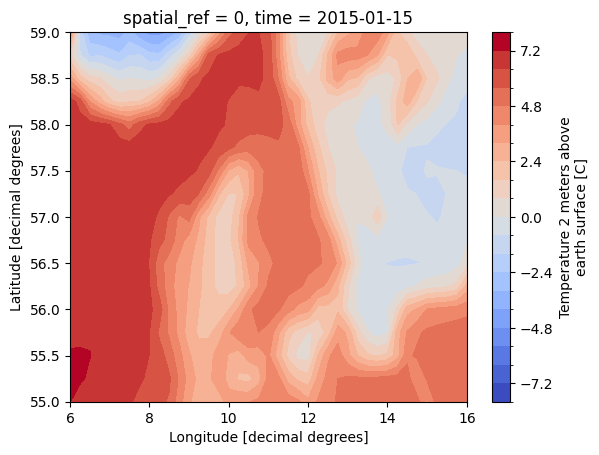

In [15]:
# select the slice of longitude values between 8 and 13 degrees
ds['temperature_2m'].isel(time=0).sel(longitude=slice(6, 16)).sel(latitude=slice(59, 55)).plot.contourf(x='longitude', y='latitude', levels=20, cmap='coolwarm')

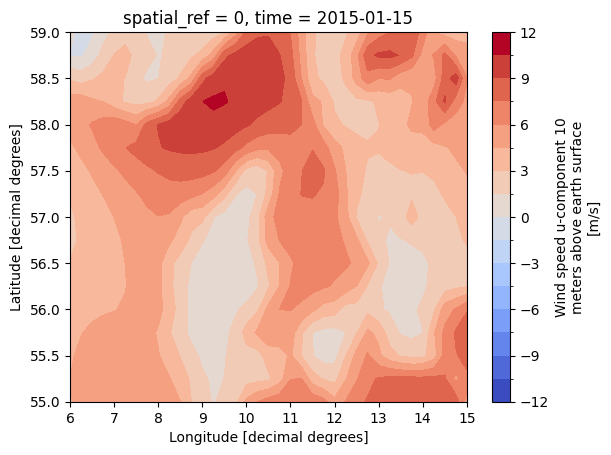

In [106]:
ds['wind_u_10m'].isel(time=0).sel(longitude=slice(6, 15)).sel(latitude=slice(59, 55)).plot.contourf(x='longitude', y='latitude', levels=20, cmap='coolwarm')

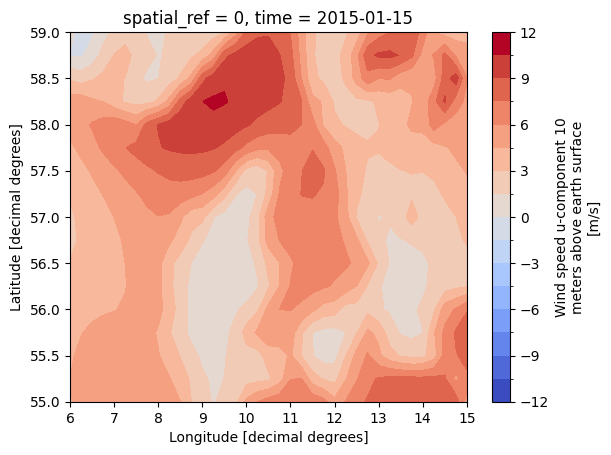

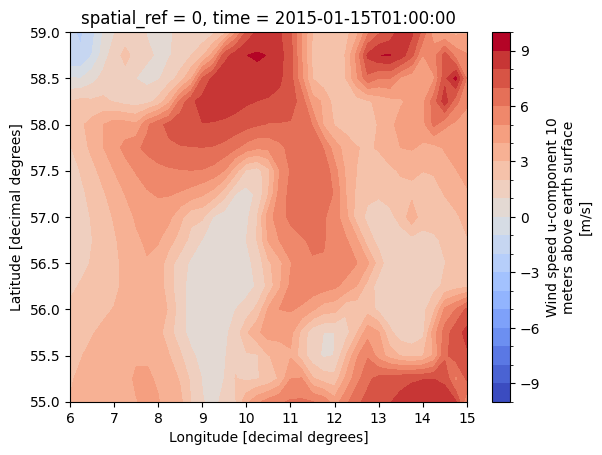

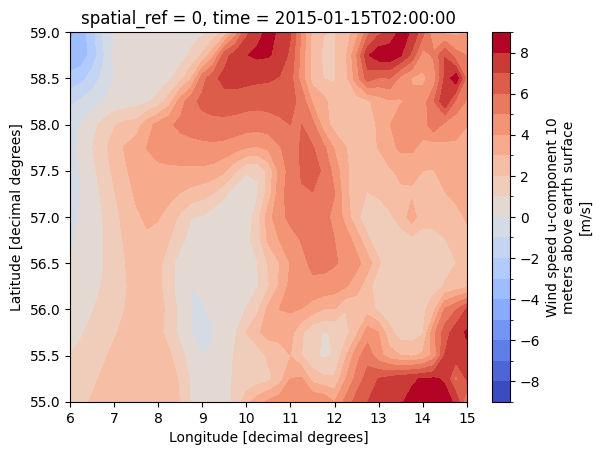

In [123]:
# Loop through first 3 hours
for t in range(3):
    ds['wind_u_10m'].isel(time=t).sel(longitude=slice(6, 15)).sel(latitude=slice(59, 55)).plot.contourf(x='longitude', y='latitude', levels=20, cmap='coolwarm')
    plt.show()

In [177]:
# creat data class for pytorch
class GFSDataset(Dataset):
    
    def __init__(
              self, 
              ds, 
              input_ntimesteps, 
              target_ntimesteps,
              variables = ['temperature_2m'],
              longitude = slice(6,16),
              latitude = slice(59,55)):
         super().__init__() #Call init function from  parent class Dataset. 
         self.input_ntimesteps = input_ntimesteps
         self.targetntimesteps = target_ntimesteps 
         self.variables = variables
         self.ds = ds[variables].sel(longitude = longitude).sel(latitude = latitude)

         # for min-max normalization for each variable. 
         self.temp_var_max = self.ds[variables[0]].attrs['statistics_approximate']['max']
         self.temp_var_min = self.ds[variables[0]].attrs['statistics_approximate']['min']
         self.wind_u_var_max = self.ds[variables[1]].attrs['statistics_approximate']['max']
         self.wind_u_var_min = self.ds[variables[1]].attrs['statistics_approximate']['min']
         self.wind_v_var_max = self.ds[variables[2]].attrs['statistics_approximate']['max']
         self.wind_v_var_min = self.ds[variables[2]].attrs['statistics_approximate']['min']
    
    def __len__(self): # num of samples  
         total_timesteps = len(self.ds['time'])
         sample_timesteps = self.input_ntimesteps + self.targetntimesteps
         return (total_timesteps - sample_timesteps)
    
    def __getitem__(self, i):
                  
         # Handle negative indexing by converting to positive
         if i < 0:
             i = len(self) + i 
             
         x_start = i
         x_end = i + self.input_ntimesteps
         y_start = x_end
         y_end = x_end + self.targetntimesteps

         x = self.ds.isel(time = slice(x_start, x_end))
         #x = torch.from_numpy(x.to_array().values) # convert to tensor  
         y = self.ds.isel(time = slice(y_start, y_end)) 
         #y = torch.from_numpy(y.to_array().values) # convert to tensor 
         return x, y 

In [178]:
data = GFSDataset(ds, 5, 5, variables=['temperature_2m', 'wind_u_10m', 'wind_v_10m'])

In [179]:
x,y = data[0] 